# MIP Control

In [7]:
import sys
sys.path.append('..')

In [8]:
%matplotlib notebook  
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [9]:
from ctrl.system.tf import PID
from ctrl.block.linear import MIMO, ShortCircuit, Subtract
from ctrl.block.logger import Logger
from ctrl.block.nl import Abs
from ctrl.block.logic import CompareAbs, Trigger
from ctrl.system.tf import DTTF
from ctrl.system.ss import DTSS

Substitute `HOST` and `PORT` with the IP address and port of your controller:

In [10]:
from ctrl.client import Controller
HOST, PORT = "localhost", 9999
#HOST, PORT = "192.168.12.197", 9999
mip = Controller(host = HOST, port = PORT)

## Probe the controller

In [11]:
print(mip.info('all'))

> Controller with 6 device(s), 8 signal(s), 4 source(s), 2 sink(s), and 0 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. imu
  6. is_running
  7. motor1
  8. motor2
> sources
  1. clock[Clock, enabled] >> clock
  2. encoder1[Encoder, enabled] >> encoder1
  3. encoder2[Encoder, enabled] >> encoder2
  4. imu[InclinometerRaw, enabled] >> imu
> filters
> sinks
  1. motor1 >> motor1[Motor, enabled]
  2. motor2 >> motor2[Motor, enabled]



## Closed-loop Control

In [17]:
mip.add_signal('theta_dot_reference')
mip.add_signal('phi_reference')
mip.add_signal('voltage')

mip.set_signal('theta_dot_reference', 0)
mip.set_signal('phi_reference', 0)

mip.add_signal('theta_dot_error')
mip.add_signal('phi_error')

mip.add_filter('sub_theta', 
               Subtract(),
               ['imu','theta_dot_reference'], 
               ['theta_dot_error'])

mip.add_filter('sub_phi', 
               Subtract(),
               ['encoder1','phi_reference'], 
               ['phi_error'])

In [18]:
Ac = np.array([[1.04198, 0.00460039],
               [-0.0156057, 0.979036]])
Bc = 2*np.pi*np.array([[0.877952, 0.0000877952], 
                       [0.500326, 0.0000500326]])
Cc = np.array([[-0.82284, 1.06356]])
Dc = 2*np.pi*np.array([[-0.0808244, -8.08244e-6]])

Bc = (100/7.4)*Bc
Dc = (100/7.4)*Dc

ctrl = DTSS(Ac,Bc,Cc,Dc)

In [19]:
mip.add_filter('controller', 
               MIMO(ctrl),
               ['theta_dot_error','phi_error'], 
               ['voltage'])
mip.add_filter('cl1',
                ShortCircuit(),
               ['voltage'],
               ['motor1'])
mip.add_filter('cl2',
                ShortCircuit(),
               ['voltage'],
               ['motor2'])

In [20]:
mip.add_sink('logger', Logger(), ['clock','imu','motor1','motor2','encoder1','encoder2','voltage','duty','theta_dot_error','phi_error'])

In [21]:
print(mip.info('all'))

> Controller with 6 device(s), 13 signal(s), 4 source(s), 3 sink(s), and 5 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. imu
  6. is_running
  7. motor1
  8. motor2
  9. phi_error
  10. phi_reference
  11. theta_dot_error
  12. theta_dot_reference
  13. voltage
> sources
  1. clock[Clock, enabled] >> clock
  2. encoder1[Encoder, enabled] >> encoder1
  3. encoder2[Encoder, enabled] >> encoder2
  4. imu[InclinometerRaw, enabled] >> imu
> filters
  1. imu, theta_dot_reference >> sub_theta[Subtract, enabled] >> theta_dot_error
  2. encoder1, phi_reference >> sub_phi[Subtract, enabled] >> phi_error
  3. theta_dot_error, phi_error >> controller[MIMO, enabled] >> voltage
  4. voltage >> cl1[ShortCircuit, enabled] >> motor1
  5. voltage >> cl2[ShortCircuit, enabled] >> motor2
> sinks
  1. motor1 >> motor1[Motor, enabled]
  2. motor2 >> motor2

In [31]:
mip.set_sink('logger',reset=True)
mip.set_source('clock',reset=True)
mip.set_source('encoder1',reset=True)
mip.set_source('encoder2',reset=True)
mip.set_filter('controller',reset=True)
with mip:
    time.sleep(10)
log = mip.read_sink('logger')

In [32]:
clock = log[:,0]
theta_dot = log[:,1]
motor1 = log[:,2]
motor2 = log[:,3]
encoder1 = log[:,4]
encoder2 = log[:,5]
voltage = log[:,6]
duty = log[:,7]
theta_dot_error = log[:,8]
phi_error = log[:,9]

data = {
    'clock': clock,
    'theta': theta_dot,
    'encoder1': encoder1,
    'encoder2': encoder2,
    'voltage': voltage,
}

<IPython.core.display.Javascript object>


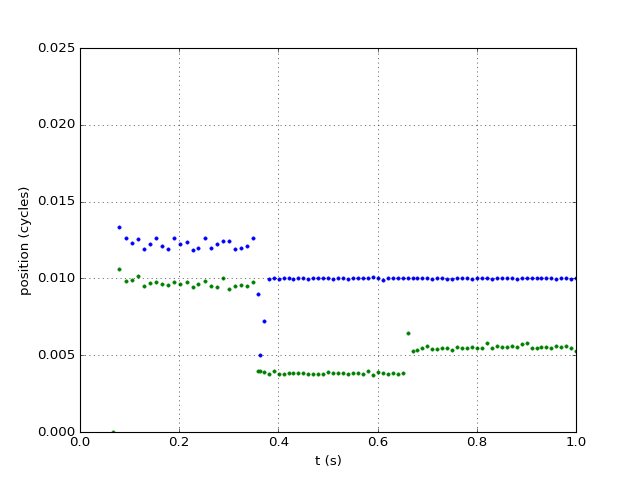

(0, 1)

In [33]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock[1:],clock[1:]-clock[:-1], '.',clock,duty,'.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()
plt.xlim(0,1)

<IPython.core.display.Javascript object>


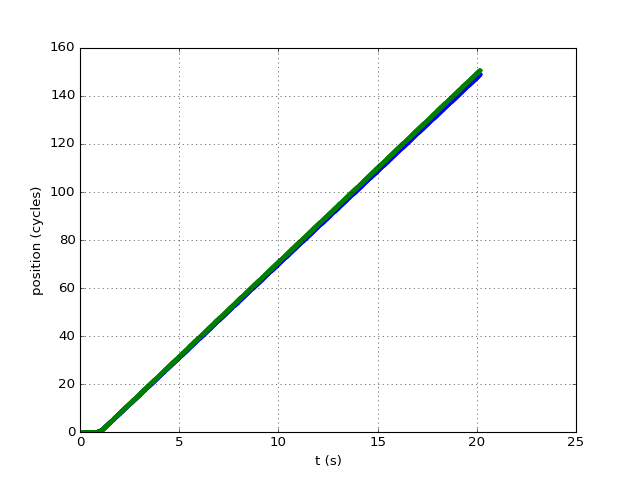

In [27]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock,encoder1,'b.',clock,encoder2,'g.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()
#plt.xlim(0,3)

<IPython.core.display.Javascript object>


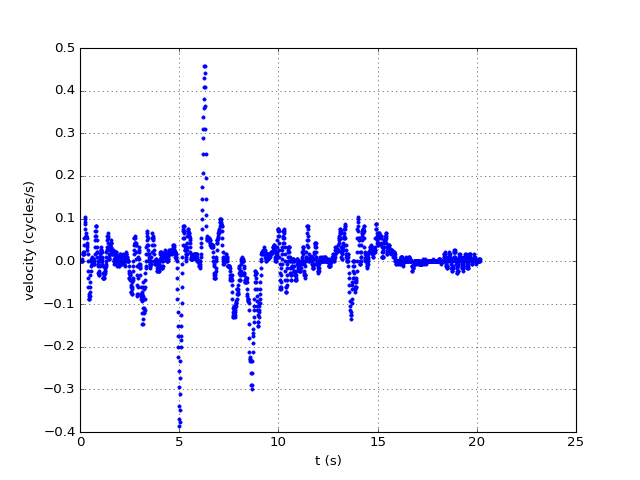

In [35]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock,theta_dot,'b.')
plt.xlabel('t (s)')
plt.ylabel('velocity (cycles/s)')
plt.grid()
#plt.xlim(0,3)

<IPython.core.display.Javascript object>


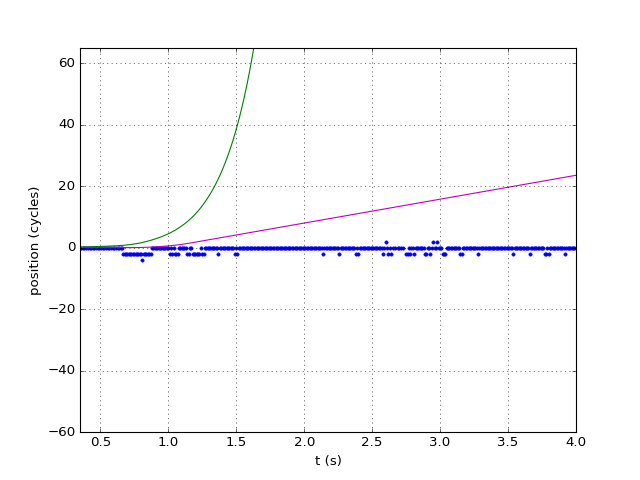

(-60, 65)

In [29]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock,theta_dot_error*360,'b.',
         clock,7.4*voltage/100,'g',
         clock,encoder1,'m'
        )
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()
plt.xlim(0.35,4)
plt.ylim(-60,65)

<IPython.core.display.Javascript object>


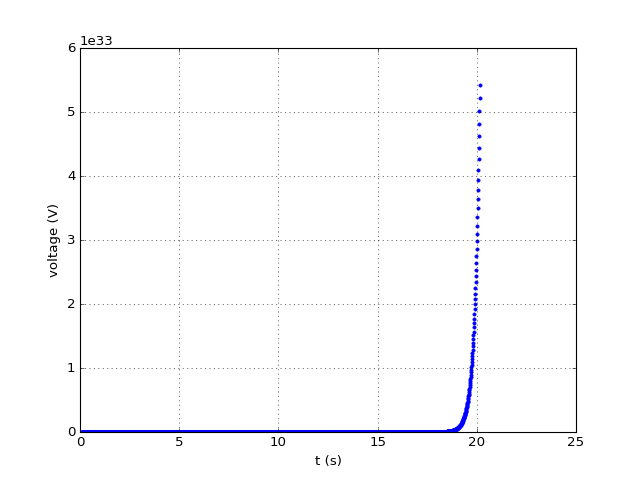

In [30]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock,(7.4/100)*voltage,'b.')
plt.xlabel('t (s)')
plt.ylabel('voltage (V)')
plt.grid()
#plt.xlim(0,3)

In [21]:
import scipy.io as spio
spio.savemat(file_name='/home/mauricio/Dropbox/ZhuZhuo/python', mdict = data)